<a href="https://colab.research.google.com/github/CoreTheGreat/HBPU-Machine-Learning-Course/blob/main/Chapter%202/ML_Chapter2_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 第二章：回归
湖北理工学院《机器学习》课程资料

作者：李辉楚吴

笔记内容概述:
* 2.1 绕不开的房价预测：准备房价预测数据
* 2.2 用线性回归预测房价
* 2.3 Gradient Descent
* 2.4 模型的评估方法
* 2.5 房价预测模型的好与坏


## 2.1 绕不开的房价预测

步骤1：从 http://lib.stat.cmu.edu/datasets/boston 导入房价预测数据

原始数据是一个列数为11的矩阵。每两行内容为一条记录，包含描述房屋的13种特征以及房屋价格。

In [ ]:
import pandas as pd # To load house price data
import numpy as np # To manipulate data

data_url = 'http://lib.stat.cmu.edu/datasets/boston' # Set url of the dataset
raw_df = pd.read_csv(data_url, sep='\s+', skiprows=22, header=None) # Load data
raw_df.head(10) # Display the raw data

,0,1,2,3,4,5,6,7,8,9,10
0,0.00632,18.00,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3
1,396.90000,4.98,24.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.02731,0.00,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8
3,396.90000,9.14,21.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.02729,0.00,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8
5,392.83000,4.03,34.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.03237,0.00,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7
7,394.63000,2.94,33.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.06905,0.00,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7
9,396.90000,5.33,36.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


步骤2：重构数据，将原始数据分为一个特征矩阵 (data) 和房价向量 (target)。

注意：特征矩阵的记录数量应与房价数量相同。

特征描述：

* [0] - 按城镇划分的犯罪率
* [1] - 面积超过25,000平方英尺（2322.58平方米）的住宅用地占比
* [2] - 非零售商业用地占比
* [3] - 是否位于查尔斯河畔 ( 1为是，0为否 )
* [4] - 氮氧化物浓度（空气质量） (单位：ppm)
* [5] - 每个住宅的平均房间数
* [6] - 1940年以前建造的自住房比例
* [7] - 到波士顿五个就业中心的加权距离
* [8] - 辐射路可达性指数
* [9] - 每10,000美元的房产税率
* [10] - 学生-教师比率
* [11] - （忽略） 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
* [12] - 低层次人口占比

房价描述:
* 自住房房价中位数（单位：千美元）

In [ ]:
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, 1:2]]) # Select features
target = raw_df.values[1::2, 2] # Select target

fts_names = [
    '犯罪率（%）',
    '大住宅用地占比（%）',
    '非零售商业用地占比（%）',
    '景观房',
    '氮氧化物浓度（ppm）',
    '平均房间数',
    '老旧房屋占比（%）',
    '离就业中心的加权距离',
    '辐射路可达性指标',
    '每万元房产税',
    '学生-教师比',
    '低层次人口占比（%）'] # Feature names

print(f'Data shape: {data.shape}, Target shape: {target.shape}') # Display the shape of data and target

Data shape: (506, 12), Target shape: (506,)


步骤3：用散点图（Scatter）展现各个特征与房价之间的关系。

注意：需要安装字体才能在figure中显式中文。

In [ ]:
!wget -O simhei.ttf 'https://www.wfonts.com/download/data/2014/06/01/simhei/chinese.simhei.ttf'
import matplotlib
matplotlib.font_manager.fontManager.addfont('simhei.ttf') # Add the font
matplotlib.rc('font', family='SimHei') # Set the font

--2024-06-30 03:38:07--  https://www.wfonts.com/download/data/2014/06/01/simhei/chinese.simhei.ttf
Resolving www.wfonts.com (www.wfonts.com)... 172.67.129.58, 104.21.1.127, 2606:4700:3031::ac43:813a, ...
Connecting to www.wfonts.com (www.wfonts.com)|172.67.129.58|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10050870 (9.6M) [application/octetstream]
Saving to: ‘simhei.ttf’

simhei.ttf          100%[===================>]   9.58M  10.8MB/s    in 0.9s    

2024-06-30 03:38:09 (10.8 MB/s) - ‘simhei.ttf’ saved [10050870/10050870]



逐一完成各个特征和房价的散点图

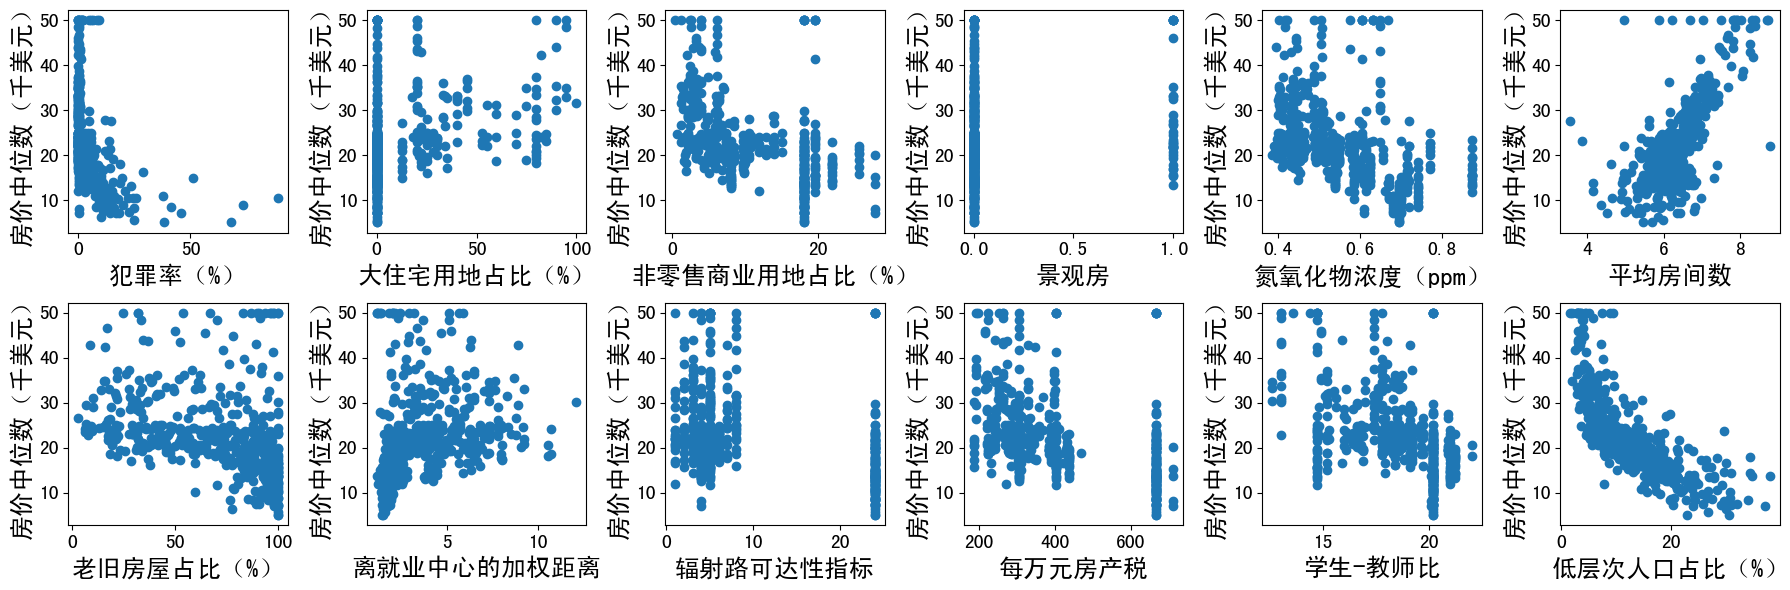

In [ ]:
import matplotlib.pyplot as plt # To draw figures

num_fts = data.shape[1] # Get the number of features
num_col = 6 # Number of columns in the figure
num_row = int(np.ceil(num_fts / num_col)) # Number of rows in the figure

label_size = 18 # Label size
ticklabel_size = 14 # Tick label size

_, axes = plt.subplots(num_row, num_col, figsize=(18, 3*num_row)) # Create a figure

for i in range(num_fts): # Loop through all features
    row = int(i / num_col) # Get the row index
    col = i % num_col # Get the column index

    ax = axes[row, col]
    ax.scatter(data[:, i], target) # Plot scatter fig of i-th feature and target
    ax.tick_params(axis='both', which='major', labelsize=ticklabel_size) # Set tick label size
    ax.set_xlabel(fts_names[i], fontsize=label_size) # Label the x-axis
    ax.set_ylabel('房价中位数（千美元）', fontsize=label_size) # Label the y-axis

plt.tight_layout() # Adjust the layout of the figure
plt.show() # Display the figure

## 2.2 用线性回归预测房价

本节内容包括三个部分：
* 准备一大堆房价数据
* 准备一堆房价预测模型
* 选择最优的房价预测模型

2.2.1 准备一大堆房价数据

画出房价与房间数量的散点图，观察房价与房间数量的关系。

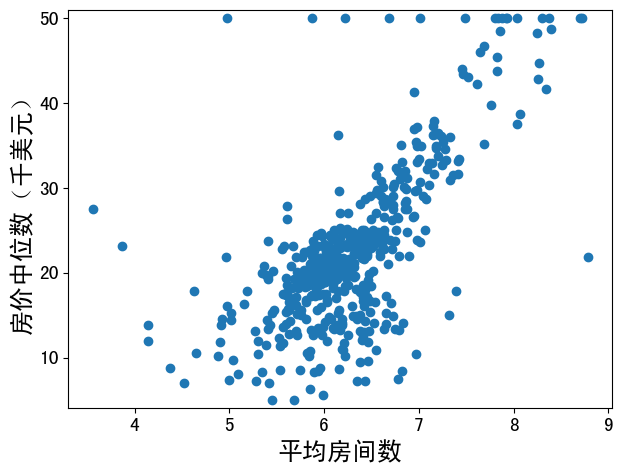

In [ ]:
x = data[:, 5] # Get the number of rooms
y = target # Get the target

def draw_scatter(x, y):
    '''
    This a specific function to draw a scatter figure of room number and house price.
    x: room number
    y: house price
    '''
    global label_size, ticklabel_size # Set global variables of font size

    fig, ax = plt.subplots() # Create a figure and a set of subplots.
    ax.scatter(x, y) # Plot the data
    ax.tick_params(axis='both', which='major', labelsize=ticklabel_size) # Set tick label size
    ax.set_xlabel('平均房间数', fontsize=label_size) # Label the x-axis
    ax.set_ylabel('房价中位数（千美元）', fontsize=label_size) # Label the y-axis

    y_min = np.min(y) # Get the minimum value of y
    y_max = np.max(y) # Get the maximum value of y
    ax.set_ylim(y_min-1, y_max+1) # Set the y-axis limits

    ax.set_position([0.12, 0.14, 0.85, 0.83]) # Set the position of the figure

    return fig, ax

fig, ax = draw_scatter(x, y)

plt.savefig('room_price.png', dpi=300) # Make figure clearer
plt.show()

2.2.2 准备一堆房价预测模型

定义预测函数并在图中增加对应的曲线。

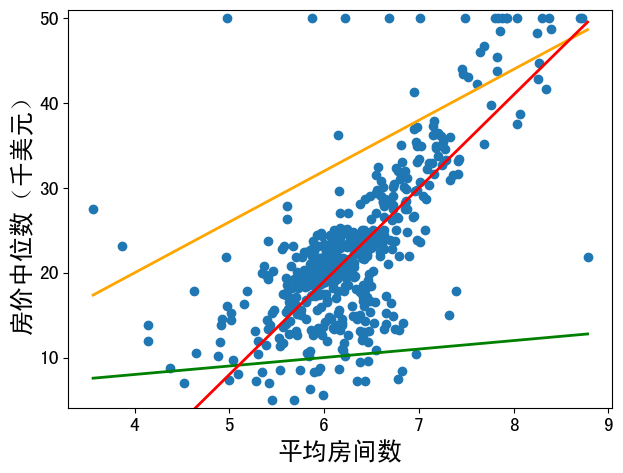

In [ ]:
def pred_linear(x, w, b):
    '''
    This a linear prediction function.
    x: feature
    b: bias
    w: weight
    '''
    return w * x + b

x_min = np.min(x)  # Get the minimum value of x
x_max = np.max(x) # Get the maximum value of x
x_linear = np.linspace(x_min, x_max, 100) # Create a sequence of x

fig, ax = draw_scatter(x, y) # Plot the scatter

line_width = 2 # Line width
ax.plot(x_linear, pred_linear(x_linear, 1, 4), color='green', linewidth=line_width) # y = x + 4
plt.savefig('room_price_f1.png', dpi=300) # Make figure clearer

ax.plot(x_linear, pred_linear(x_linear, 6, -4), color='orange', linewidth=line_width) # y = 6x - 4
plt.savefig('room_price_f2.png', dpi=300) # Make figure clearer

ax.plot(x_linear, pred_linear(x_linear, 11, -47), color='red', linewidth=line_width) # y = 11x - 47
plt.savefig('room_price_f3.png', dpi=300) # Make figure clearer

plt.show()

练习：尝试构建其它的预测模型

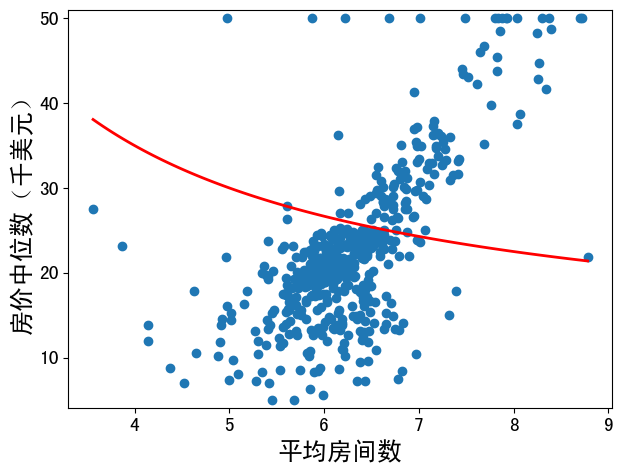

In [ ]:
def pred_nonlinear(x, w, b):
    '''
    This an example of non-linear prediction function.
    x: feature
    b: bias
    w: weight

    Return:
    y: prediction
    '''
    return w / x + b

fig, ax = draw_scatter(x, y) # Plot the scatter
ax.plot(x_linear, pred_nonlinear(x_linear, 100, 10), color='red', linewidth=line_width) # 100 / x + 10
plt.show()

2.2.3 选择最优的房价预测模型

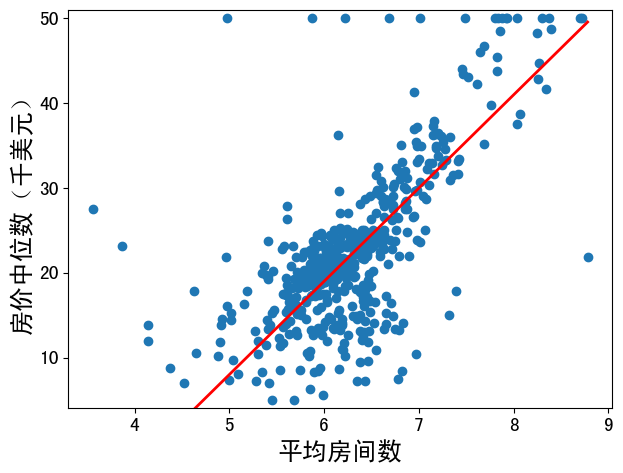

In [ ]:
'''
Drawing a figure to explain why we need loss function in the slides.
It is not necessary to run this cell.
'''

fig, ax = draw_scatter(x, y) # Plot the scatter
ax.plot(x_linear, pred_linear(x_linear, 11, -47), color='red', linewidth=line_width) # y = 11x - 47
plt.savefig('room_price_onlyf3.png', dpi=300) # Make figure clearer
plt.show()

构建损失函数

In [ ]:
def loss(x, y, w, b):
    '''
    This a loss function for linear regression.
    x: feature
    y: target
    w: weight
    b: bias

    Return:
    l: loss
    '''

    l = 0
    for i in range(len(x)):
        l += (pred_linear(x[i], w, b) - y[i]) ** 2
    return l / len(x)

print(f'Loss of f1: {loss(x, y, 1, 4)}')

Loss of f1: 225.96083606126484


计算所有预测函数的损失

In [ ]:
w_min, w_max = -100, 100 # Weight range
b_min, b_max = -100, 100 # Bias range
param_num = 200 # Number of per parameter

w_list = np.linspace(w_min, w_max, param_num) # Create a sequence of w
b_list = np.linspace(b_min, b_max, param_num) # Create a sequence of b

w_grid, b_grid = np.meshgrid(w_list, b_list) # Create a grid of w and b
loss_grid = np.zeros((param_num, param_num)) # Create a grid of loss

for i in range(param_num):
    for j in range(param_num):
        loss_grid[i, j] = loss(x, y, w_grid[i, j], b_grid[i, j]) # Calculate the loss of each parameter

Total time: 15.269364833831787
 Average time to comput once:0.000382


用热力图展示loss、w、b之间的关系，并找出最优解

<ipython-input-86-4b5f66bb8cc2>:34: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig('loss_heat.png', dpi=300) # Make figure clearer
<ipython-input-86-4b5f66bb8cc2>:43: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig('loss_with_mark.png', dpi=300) # Make figure clearer
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


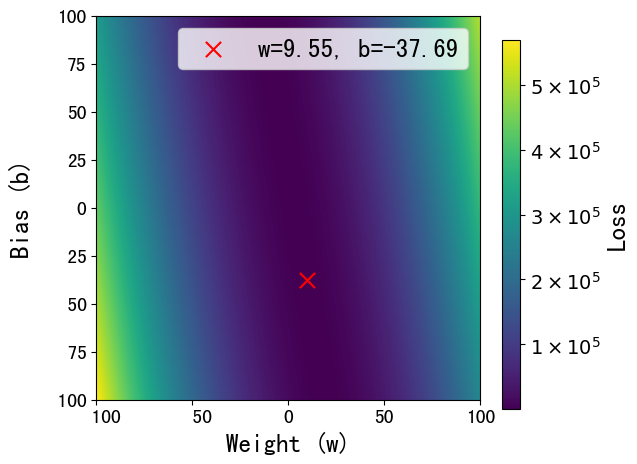

In [ ]:
# Set figure
fig, ax = plt.subplots()

# Plot the loss
im = ax.imshow(loss_grid, extent=[w_min, w_max, b_min, b_max], origin='lower', cmap='viridis')

# Custom formatter for colorbar labels
# For example:
# Change 400000 to 4x10^5
from matplotlib.ticker import FuncFormatter
def format_ticks(value, tick_number):
    if value == 0:
        return '0'
    else:
        exponent = int(np.log10(value))
        mantissa = value / (10 ** exponent)
        return r'${:.0f} \times 10^{{{}}}$'.format(mantissa, exponent)

# Set colorbar ticks
formatter = FuncFormatter(format_ticks) # Create a formatter
cbar = fig.colorbar(im, ax=ax, label='Loss', format=formatter) # Set colorbar
cbar.ax.set_ylabel('Loss', fontsize=label_size) # Set fontsize for colorbar label
cbar.ax.tick_params(labelsize=ticklabel_size) # Set cbar tick label size

# Set x-axis and y-axis
ax.set_xlabel('Weight (w)', fontsize=label_size)
ax.set_ylabel('Bias (b)', fontsize=label_size)

ax.set_position([0.15, 0.13, 0.60, 0.8]) # Set the position of the figure

# Set tick label size
ax.tick_params(axis='both', which='major', labelsize=ticklabel_size)

plt.savefig('loss_heat.png', dpi=300) # Make figure clearer

# Mark the point of lowest loss
min_loss_idx = np.unravel_index(np.argmin(loss_grid), loss_grid.shape)
min_w = w_grid[min_loss_idx]
min_b = b_grid[min_loss_idx]
ax.scatter(min_w, min_b, color='red', marker='x', s=120, label=f'w={min_w:.2f}, b={min_b:.2f}')
ax.legend(fontsize=label_size)

plt.savefig('loss_with_mark.png', dpi=300) # Make figure clearer
plt.show()

展示最优的房价预测函数

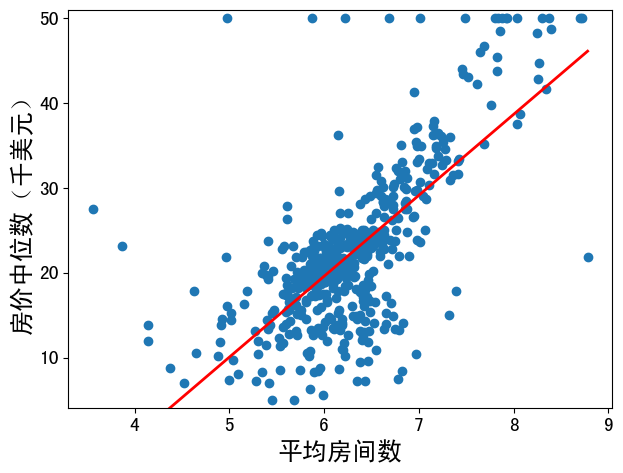

In [ ]:
'''
Drawing a figure of the best estimation function
'''

fig, ax = draw_scatter(x, y) # Plot the scatter
ax.plot(x_linear, pred_linear(x_linear, min_w, min_b), color='red', linewidth=line_width) # y = 11x - 47
plt.savefig('room_price_best.png', dpi=300) # Make figure clearer
plt.show()